In [1]:
import fasttext
import numpy as np

import matplotlib.pyplot as plt
# load overall model
model_path = f"trained_model/norman_1066_1216.bin"
model_norman = fasttext.load_model(model_path)

model_path = f"trained_model/ang_all.bin"
model_ang = fasttext.load_model(model_path)

In [2]:
norman_words = list(model_norman.words) 
embedding_matrix_norman = np.array([model_norman.get_word_vector(word) for word in norman_words])

In [3]:
ang_words = set(model_norman.words) 
embedding_matrix_ang = np.array([model_ang.get_word_vector(word) for word in ang_words])

# alignment

## orthogonal_procrustes

In [4]:
from scipy.linalg import orthogonal_procrustes
# transform ang
R, scale = orthogonal_procrustes(embedding_matrix_ang, embedding_matrix_norman)
Ang_transformed = embedding_matrix_ang.dot(R) * scale

In [17]:
norms = np.linalg.norm(Ang_transformed, axis=1)
word_emb_norm = (Ang_transformed.T / norms).T

/var/folders/s2/bjtyvybn0kv3rwjkn5xht9_m0000gn/T/ipykernel_62485/822981411.py:2: RuntimeWarning: invalid value encountered in divide
  word_emb_norm = (Ang_transformed.T / norms).T


In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb_norm)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(ang_words):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

In [8]:
# transform norman
R, scale = orthogonal_procrustes(embedding_matrix_norman, embedding_matrix_ang)
Norman_transformed = embedding_matrix_norman.dot(R) * scale

In [9]:
norms = np.linalg.norm(Norman_transformed, axis=1)
word_emb_norm = (Norman_transformed.T / norms).T

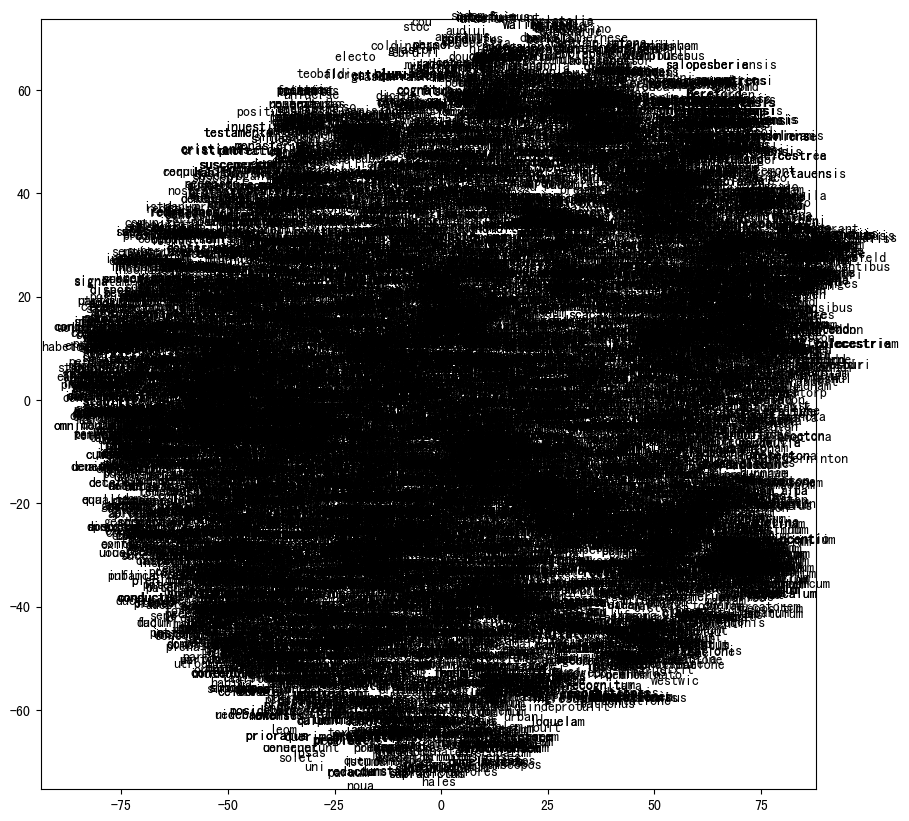

In [10]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb_norm)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(norman_words):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

## Wasserstein Procrustes

In [11]:
import ot  # Import POT: Python Optimal Transport library

def align_embeddings_via_procrustes(X, Y):
    """
    Align two sets of embeddings (X and Y) using an approach inspired by Wasserstein Procrustes.

    Parameters:
    - X: Source embeddings (numpy array of shape (n_samples, n_features))
    - Y: Target embeddings (numpy array of shape (n_samples, n_features))

    Returns:
    - Y_aligned: Aligned target embeddings to the source embeddings space
    """
    # Normalize embeddings to unit norm
    X_normalized = X / np.linalg.norm(X, axis=1, keepdims=True)
    Y_normalized = Y / np.linalg.norm(Y, axis=1, keepdims=True)
    
    # Compute the cost matrix as the negative cosine similarity or Euclidean distance
    M = ot.dist(X_normalized, Y_normalized, metric='euclidean')
    
    # Compute the optimal transport plan using the Sinkhorn algorithm
    transport_plan = ot.sinkhorn2(np.ones((X.shape[0],)), np.ones((Y.shape[0],)), M, 1e-1)[0]
    
    # Map Y to X space using the transport plan
    Y_mapped = transport_plan.dot(Y_normalized)
    
    # Compute the optimal orthogonal transformation (SVD)
    U, _, Vt = np.linalg.svd(Y_mapped.T.dot(X_normalized), full_matrices=False)
    Q = U.dot(Vt)  # Optimal rotation matrix
    
    # Apply the transformation to Y
    Y_aligned = Y_normalized.dot(Q)
    
    return Y_aligned



/Users/zhanggangquan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
Y_aligned = align_embeddings_via_procrustes(Ang_transformed, Norman_transformed)


/var/folders/s2/bjtyvybn0kv3rwjkn5xht9_m0000gn/T/ipykernel_62485/496162415.py:15: RuntimeWarning: invalid value encountered in divide
  X_normalized = X / np.linalg.norm(X, axis=1, keepdims=True)
/Users/zhanggangquan/anaconda3/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


IndexError: invalid index to scalar variable.

In [ ]:
Y_aligned